# Decision Trees Learning
## Author: Ganesh

## Summary
In this work, your task is to develop a machine learning classifier for predicting female patients that at high risk of Diabetes. Your model is to support clinicians in identifying patients who are likely to have “Diabetes”. The dataset has 9 attributes in total including the “target/label” attribute. The full dataset is available on ELE under assessment coursework 1. The dataset consists of the following:


## Dataset

1. preg: Number of times pregnant
2. plas: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. pres: Diastolic blood pressure (mm Hg)
4. skin: Triceps skin fold thickness (mm)
5. insu: 2-Hour serum insulin (mu U/ml)
6. mass: Body mass index (weight in kg/(height in m)^2)
7. pedi: Diabetes pedigree function
8. age: Age (years)
9. class: Class variable (0 or 1)

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
import seaborn as sns

dia_all = pd.read_csv("diabetes.txt")
def getData():
    return dia_all.copy()

## Seperate the inpout (attributes) from target (label)

In [16]:
sourcevars = getData().iloc[:,:-1] #all rows + all columns except the last one
targetvar = getData().iloc[:,-1:] #all rows + only the last column

In [17]:
sourcevars.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [18]:
targetvar.head()



,class
0,tested_positive
1,tested_negative
2,tested_positive
3,tested_negative
4,tested_positive


# 1.Exploratory data analysis:

## Taks 1.a [Calculate Stats From the Data]

In [70]:
'''Calculate the mean, median, standard-deviation and correlation matrix for all the input attributes using Pandas package'''

def getStats(data): 
    # Correlation between the features
    data = data.replace({"class":     {"tested_positive": 1, "tested_negative": 0}})
    corr = data.corr() 
    #Getting stats from Data
    stats = data.iloc[:,:-1].describe()
    #Getting additional stats from Data for outlier detection
    statsExtra = data.iloc[:,:-1].aggregate([iqr,bottomRange,upperRange])
    statsExtra.index = ['IQR','outlier_bottom_range','outlier_upper_range']
    return pd.concat([stats, statsExtra]),corr

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

def bottomRange(x):
    return x.quantile(0.25) - 1.5 * iqr(x)

def upperRange(x):
    return x.quantile(0.75) + 1.5 * iqr(x)

stats,corr = getStats(getData())
stats

,preg,plas,pres,skin,insu,mass,pedi,age
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000
IQR,5.000000,41.250000,18.000000,32.000000,127.250000,9.300000,0.382500,17.000000
outlier_bottom_range,-6.500000,37.125000,35.000000,-48.000000,-190.875000,13.350000,-0.330000,-1.500000


## Taks 1.b [Chart]

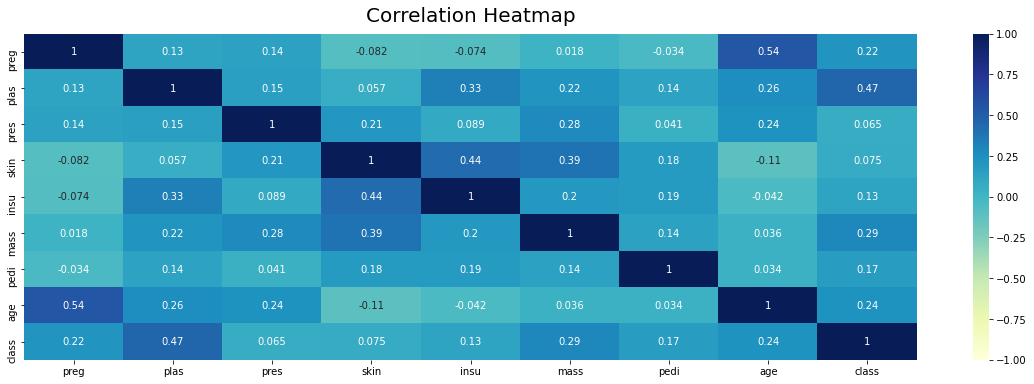

In [71]:
stats, corr = getStats(getData())
plt.figure(figsize=(20, 6))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap="YlGnBu",cbar=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12);

#This chart provides the details of the correlation of the features.
#We can see the corelation of the features with the disease progression(class) or output label 
#we can see that Plas,mass(bmi),age are higly corrolated compared to other features to the disease progression

# 2. Classfication

In [169]:
#Defining the class for reuse purpose

class DecisionTree:
    
    #Processes the data by reprocessing and removing outlier and running prediction by given inputs
    def ProcessData(self,data,criteria='gini',randomState=1,maxDepth=4,minSampleSplit=2,minLeafSplit=2) :
        data = self.preprocess_data(data)
        sourcevars = data.iloc[:,:-1] #all rows + all columns except the last one
        targetvar = data.iloc[:,-1:]
        return self.decisionTreeLearnPredict(sourcevars,targetvar,0.3,criteria,randomState,maxDepth,minSampleSplit,minLeafSplit)

    #This is the method for preprocessing of the data
    def preprocess_data(self,data) :
        stats,corr = getStats(data)
        self.processMissingValue(data,stats)
        data = self.handleOutliers(data,stats)
        return data

    '''This is the method for outlier handling
       This removes the outlier using the quantile logic
       quantile logic is written in the getStats method
    '''
    def handleOutliers(self,data,stats):
        for feature in data.columns :
            if feature in stats.columns:
                data= data[data[feature].between(stats.loc["outlier_bottom_range",feature],stats.loc["outlier_upper_range",feature])]
        return data

    #Missing value to be updated with Median
    def processMissingValue(self,data,stats) :
        #Since Insulin, Blood Presure, BMI cannot be zero, we are going to remove them
        data = data[(data.pres != 0) & (data.insu != 0) & (data.mass != 0)] 
        #data.fillna(value=stats.loc["median"],inplace=True)
    
    #This is the predection logic This also returns the accuracy, True positive rate, precision
    def decisionTreeLearnPredict(self,inputData,target,tSize,criteria,randomState,maxDepth,minSampleSplit,minLeafSplit) :
        #Train Test Split
        train_example, test_example, train_label, test_label = train_test_split(inputData,target,stratify=target)
    
        #Decision Tree cliassification using different criterion random state is set with 10 different random numbers
        treeClassifier = DecisionTreeClassifier(random_state=randomState,criterion=criteria,max_depth=maxDepth,min_samples_split=minSampleSplit,min_samples_leaf=minLeafSplit)
        #print('tsize',tSize,len(test_label),len(train_label),'criteria',criteria,'randomState',randomState,'maxDepth',maxDepth,'minSampleSplit',minSampleSplit,'minLeafSplit',minLeafSplit)
       
        #Model Fitting
        treeClassifier.fit(train_example,train_label)
    
        #Prediction
        test_prediction = treeClassifier.predict(test_example)
    
        #Prediction Evaluation by Accuracy, True Positive Rate, Precision
        accuracy = accuracy_score(test_label,test_prediction)
        truePositiveRate=recall_score(test_label,test_prediction,pos_label='tested_positive')
        precision = precision_score(test_label,test_prediction,pos_label='tested_positive')
    
        return {'Accuracy':accuracy*100,'True Positive Rate':truePositiveRate*100,'Precision':precision*100}
        
    def buildDataReport(self,result,title,xlabel="Runs",ylabel="Score",shape=(20,5),lineNeeded=False,barNeeded=True):
        
        fig = plt.gcf()
        fig.set_size_inches(shape)
        #colors = plt.cm.BuPu(np.linspace(0, 0.5, len(result.index)))
        w=0.25
        
        accuracyBar = np.arange(len(result.index))
        truePositiveBar = [i+w for i in accuracyBar]
        precisionBar = [i+w for i in truePositiveBar]
        if barNeeded:
            plt.bar(accuracyBar,result.iloc[:,0],w,label="accuracy",color='blue')
            plt.bar(truePositiveBar,result.iloc[:,1],w,label="truePositive",color='green')
            plt.bar(precisionBar,result.iloc[:,2],w,label="precision",color='orange') 
            
        
        if lineNeeded :
            plt.plot(accuracyBar,result.iloc[:,0],w,label="accuracy",color='blue')
            plt.plot(accuracyBar,result.iloc[:,1],w,label="truePositive",color='green')
            plt.plot(accuracyBar,result.iloc[:,2],w,label="precision",color='orange')
            w=0
        
        plt.ylim([0,100])
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.xticks(accuracyBar+w,result.index)
        plt.title(title)
        plt.legend()
        plt.show()

## Task 2.a [Build Decision Tree Using Gini]

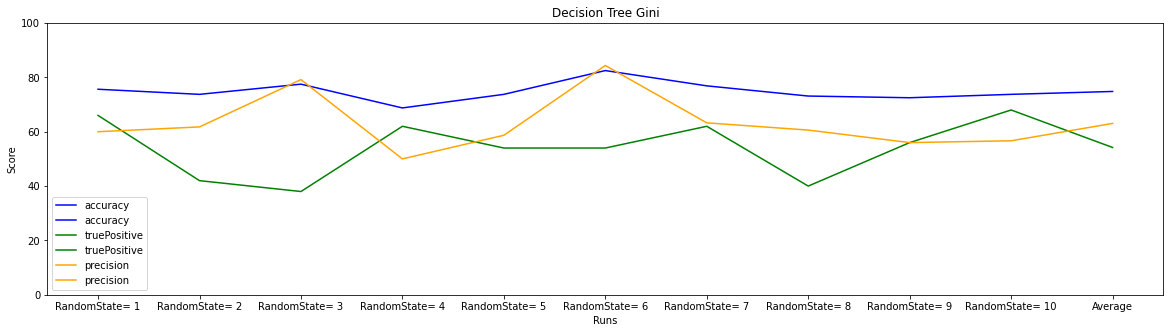

In [151]:
'''Build a Decision Tree (DT) classifier using the training dataset and evaluate the performance on the “testing” set. 
Repeat this experiment 10 time using a different random split in each iteration. 
Show the performance (i.e. accuracy, true positive rate and precision) for each iteration and 
the average of the 10 iterations for each measure
'''
#This code will execute the Decision Tree with Gini Criteria
#n=10 is number of runs

n=10

#This is the custom decision tree class written above for reuse purpose
decisonTreeClassifer = DecisionTree()

#Results will be placed in giniResult
giniResult = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
for i in range(1,n+1):
    data = getData() 
    giniResult = giniResult.append(pd.Series(decisonTreeClassifer.ProcessData(data,randomState=i),name=('RandomState= '+str(i))))
#Finding the average of the results
giniResult = giniResult.append(pd.Series(giniResult.agg(np.mean),name="Average"))
decisonTreeClassifer.buildDataReport(giniResult,"Decision Tree Gini",lineNeeded=True,barNeeded=False)

## Task 2.b [Build Decision Tree Using Entropy]

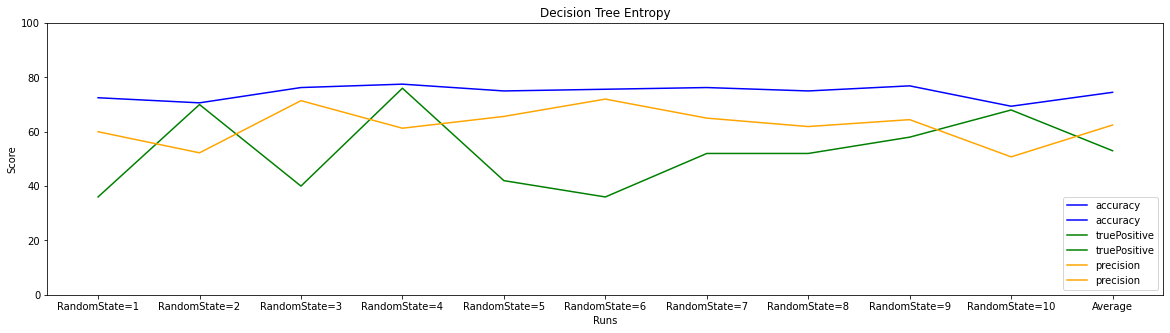

In [152]:
'''Compare the performance of the experiment above when you change the criterion from Gini impurity (“gini”) to information gain (“entropy”). Repeat this experiment 10 time using a different random split in each iteration as in section in part (a)'''

#This code will execute the Decision Tree with Entropy Criteria
#n=10 is number of runs
n=10
#print('-'*40,'Result(Entropy) Average Of  %d Runs'%n,'-'*40)

#This is the custom decision tree class written above for reuse purpose
decisonTreeClassifer = DecisionTree()

#Results will be placed in entropyResult
entropyResult = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
for i in range(1,n+1):
    data = getData()
    entropyResult = entropyResult.append(pd.Series(decisonTreeClassifer.ProcessData(data,criteria='entropy',randomState=i),name=('RandomState='+str(i))))

#Finding the average of the results
entropyResult = entropyResult.append(pd.Series(entropyResult.agg(np.mean),name="Average"))
decisonTreeClassifer.buildDataReport(entropyResult,"Decision Tree Entropy",lineNeeded=True,barNeeded=False)

## Task 2.C[Comparing the decision Tree's(a & b) performance]

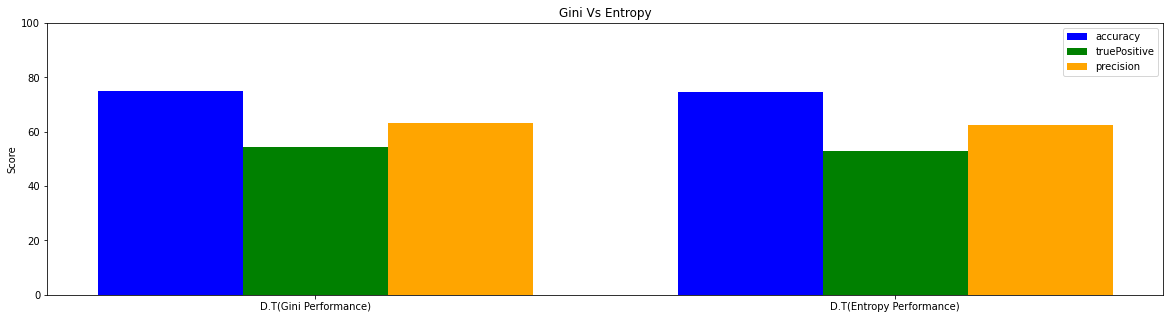

In [153]:
'''Compare the performance of the two classifiers (a) and (b) over the 10 repeats using a suitable chart'''

giniAvgResult = giniResult.iloc[-1,:]
giniAvgResult.name="D.T(Gini Performance)"

entropyAvgResult = entropyResult.iloc[-1,:]
entropyAvgResult.name="D.T(Entropy Performance)"

resultAvgData = pd.concat([giniAvgResult,entropyAvgResult],axis=1)
decisonTreeClassifer.buildDataReport(resultAvgData.T,"Gini Vs Entropy","","Score")

## Task 2.d[Impact of standardizing on D.T]

Do you think standardizing the data before applying DT would improve the performance for this dataset? Why?

Decision Tree or Tree-based algorithms are relatively insensitive to the scale of the features or standardization 
because of below reasons:

    •	 A decision tree is only splitting a node based on a single feature. By changing the scale, 
         the decision process will not have any impact. 
         E.g., let us take feature Y which is 200<Y<300; If we scale down the Y by 100 times 
            then, 2 > Y/100 > 3, even then the decision would not have changed.	

    •	 The decision tree splits a node on a feature that increases the homogeneity of the node. 
          Other features do not influence this split on a feature. So, there is virtually no effect 
        of the remaining features on the split. 

This is what makes them invariant to the scale of the features or standardization!

# 3. Classification DT Paramters Impact

## Task 3.a[min_samples_split Test]

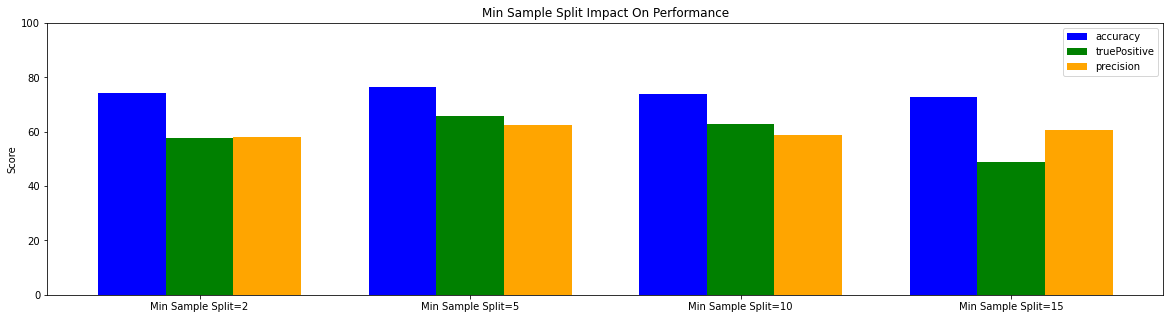

,Accuracy,True Positive Rate,Precision
Min Sample Split=2,74.125,57.6,58.212200
Min Sample Split=5,76.375,65.6,62.374388
Min Sample Split=10,74.000,62.8,58.869361
Min Sample Split=15,72.875,48.8,60.735628


In [165]:
'''How does increasing the minimum number of samples required to split an internal node parameter in the DT algorithm 
(i.e. min_samples_split = 2, 5, 10 and 15) affect the accuracy on the test set? 
Show your results using a suitable chart or table'''

n=5
decisonTreeClassifer = DecisionTree()

#Results will be placed in minSplitResult
minAvgSplitResult = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
for i in [2,5,10,15]:
    minSplitResult = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
    for j in range(n): 
        data = getData()     
        minSplitResult = minSplitResult.append(pd.Series(decisonTreeClassifer.ProcessData(data,minSampleSplit=i)),ignore_index=True)
    #Finding the average of the 'n' runs for each Min Sample Split
    minAvgSplitResult = minAvgSplitResult.append(pd.Series(minSplitResult.agg(np.mean),name="Min Sample Split=%d"%i))


decisonTreeClassifer.buildDataReport(minAvgSplitResult,"Min Sample Split Impact On Performance","")
minAvgSplitResult

## Task 3.b[max_depth test]

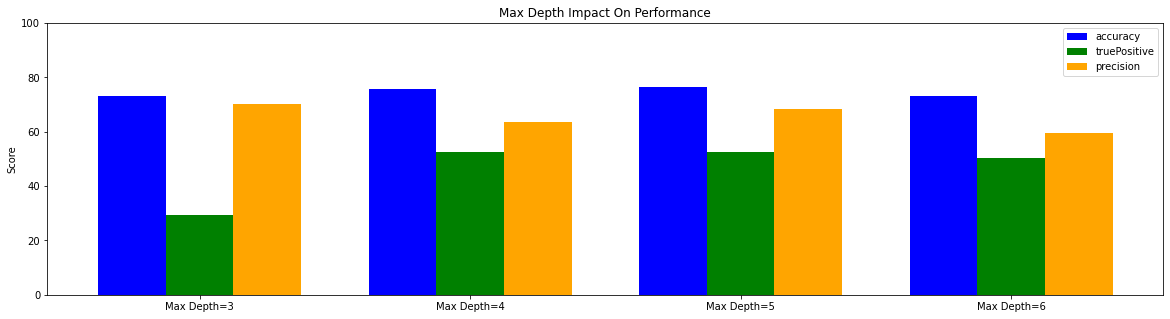

,Accuracy,True Positive Rate,Precision
Max Depth=3,73.125,29.2,70.045884
Max Depth=4,75.625,52.4,63.425277
Max Depth=5,76.625,52.4,68.306268
Max Depth=6,73.000,50.4,59.594672


In [166]:
'''How does increasing the maximum depth of the decision tree parameter 
(i.e. max_depth = 3, 4, 5 and 6) affect the accuracy on the test set? 
Show your results using a suitable chart or table'''

n=5
decisonTreeClassifer = DecisionTree()

#Results will be placed in maxAvgDepthResult
maxAvgDepthResult = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
for i in range(3,7):
    maxDepthResults = pd.DataFrame(columns=['Accuracy','True Positive Rate','Precision'])
    for j in range(n): 
        data = getData()     
        maxDepthResults = maxDepthResults.append(pd.Series(decisonTreeClassifer.ProcessData(data,maxDepth=i)),ignore_index=True)
    
    #Finding the average of 'n' runs results for each maxDepth
    maxAvgDepthResult = maxAvgDepthResult.append(pd.Series(maxDepthResults.agg(np.mean),name="Max Depth=%d"%i))

#Printing the Performance Impact by changing the max depth    
decisonTreeClassifer.buildDataReport(maxAvgDepthResult,"Max Depth Impact On Performance","")
maxAvgDepthResult

